# 0.0 Libraries

In [1]:
#data manipulation
import pandas as pd
import numpy as np

#data visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

#machine learning
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn import svm

## 0.1 Helper functions

In [94]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def mean_absolute_percentage_error (y, yhat):
    return np.mean(np.abs((y - yhat)/y))
    
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y , yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'model name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number{}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - dtt.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - dtt.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & 
                                (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name, 
                        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str) , 
                        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str), 
                        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, 
                         index=[0])

## 0.2 Loading data

In [2]:
data_raw = pd.read_csv('datasets/credit_risk_dataset.csv')

# 1.0 Data description

In [3]:
df1 = data_raw.copy()

In [4]:
df1.sample(20)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
20419,34,40000,OWN,18.0,MEDICAL,B,8000,11.36,0,0.20,N,10
26509,32,105000,MORTGAGE,17.0,MEDICAL,C,5000,14.65,0,0.05,N,9
21303,27,20400,RENT,3.0,MEDICAL,A,5500,6.91,0,0.27,N,7
13315,26,36120,RENT,3.0,MEDICAL,C,2800,13.35,1,0.08,N,4
14477,24,108000,MORTGAGE,4.0,PERSONAL,A,10000,5.99,0,0.09,N,2
17221,25,80000,MORTGAGE,9.0,VENTURE,A,12000,7.88,0,0.15,N,3
28545,31,60000,OWN,0.0,VENTURE,B,24250,12.18,0,0.40,N,5
6826,26,62065,RENT,7.0,PERSONAL,B,6000,11.12,1,0.10,N,3
11036,23,42000,RENT,1.0,MEDICAL,A,4100,7.88,0,0.10,N,2
31468,38,48300,RENT,3.0,MEDICAL,C,14000,13.22,0,0.29,Y,14


In [5]:
df1.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [7]:
df1.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [8]:
df1.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [9]:
df1.duplicated().sum()

165

In [10]:
df1.shape

(32581, 12)

## 1.1 Rename columns

In [11]:
cols_new = ['age', 'income', 'home_ownership', 'employment_length', 
            'loan_intent', 'loan_grade', 'loan_amnt',
            'loan_int_rate', 'is_default', 'loan_percent_income',
            'default_history', 'credit_history_length']

In [12]:
df1.columns = cols_new

## 1.2 Dealing with NA values

In [13]:
df1 = df1.dropna(axis=0).reset_index()

In [14]:
df1.isnull().sum()

index                    0
age                      0
income                   0
home_ownership           0
employment_length        0
loan_intent              0
loan_grade               0
loan_amnt                0
loan_int_rate            0
is_default               0
loan_percent_income      0
default_history          0
credit_history_length    0
dtype: int64

## 1.3 Outliers

In [15]:
df1.sort_values(by=['age'], ascending=False)

,index,age,income,home_ownership,employment_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,is_default,loan_percent_income,default_history,credit_history_length
74,81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
28388,32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25
163,183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
508,575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
28572,32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0,0.11,N,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10452,11902,20,77052,MORTGAGE,4.0,EDUCATION,B,24250,11.36,0,0.31,N,2
4915,5648,20,94000,RENT,4.0,EDUCATION,D,5000,16.02,0,0.05,N,3
6405,7327,20,42000,RENT,4.0,VENTURE,B,6500,11.71,0,0.15,N,2
8715,9926,20,65000,MORTGAGE,4.0,EDUCATION,B,4800,9.99,0,0.07,N,2


In [16]:
df1.sort_values(by=['employment_length'], ascending=False)

,index,age,income,home_ownership,employment_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,is_default,loan_percent_income,default_history,credit_history_length
0,0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
186,210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4
28440,32355,78,48000,RENT,41.0,MEDICAL,A,3000,7.51,0,0.06,N,25
28580,32515,53,106000,MORTGAGE,38.0,PERSONAL,B,20000,9.88,0,0.19,N,23
28504,32428,58,49000,MORTGAGE,34.0,MEDICAL,D,7500,13.55,1,0.15,Y,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5614,6447,22,40000,RENT,0.0,VENTURE,A,6000,8.32,0,0.15,N,3
25745,29260,39,17721,OWN,0.0,DEBTCONSOLIDATION,C,3975,11.97,1,0.22,Y,15
25746,29262,39,17760,OWN,0.0,MEDICAL,A,4375,5.42,1,0.25,N,17
25748,29264,39,67000,RENT,0.0,VENTURE,D,24000,15.31,1,0.36,N,11


In [17]:
df1 = df1.drop(df1[df1['age'] > 100].index, axis=0)

In [18]:
df1 = df1.drop(df1[df1['employment_length'] > 100].index, axis=0)

## 1.4 Change Dtypes

In [19]:
df1['is_default'] = df1['is_default'].astype('object')

In [20]:
df1.dtypes

index                      int64
age                        int64
income                     int64
home_ownership            object
employment_length        float64
loan_intent               object
loan_grade                object
loan_amnt                  int64
loan_int_rate            float64
is_default                object
loan_percent_income      float64
default_history           object
credit_history_length      int64
dtype: object

# 2.0 Feature Engineering

In [21]:
df2 = df1.copy()

## 2.1 Grouping variables

In [22]:
df2['age_group'] = pd.cut(df2['age'],
                          bins=[20, 26, 40, 60, 100],
                          labels=['young_adult', 'adult', 'late_adulthood', 'elderly'])

In [23]:
df2['age_group'].dtype

CategoricalDtype(categories=['young_adult', 'adult', 'late_adulthood', 'elderly'], ordered=True)

In [24]:
df2['income_group'] = pd.cut(df2['income'],
                             bins = [0, 25000, 50000, 75000, 100000, float('inf')],
                             labels = ['low', 'low_middle', 'middle', 'high_middle', 'high'])

In [25]:
df2['loan_amnt_group'] = pd.cut(df2['loan_amnt'],
                                bins = [0, 5000, 10000, 15000, float('inf')], 
                                labels = ['small', 'medium', 'large', 'very_large'])

## 2.2 Creating ratio columns

In [26]:
df2['loan_to_income'] = df2['loan_amnt'] / df2['income']

In [27]:

df2['loan_to_emp_len'] = df2['employment_length'] / df2['loan_amnt']

In [28]:
df2['int_rate_to_loan'] = df2['loan_int_rate'] / df2['loan_amnt']

# 3.0 Exploratory Data Analysis

In [29]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

In [30]:
fig=px.pie(df3, values='index', names='is_default', title='Defaulting clients')
fig.show()

### 3.1.2 Distributions

<Axes: xlabel='age', ylabel='Count'>

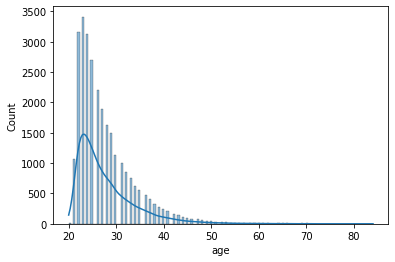

In [31]:
#AGE
sns.histplot(df3['age'], kde=True)

<Axes: xlabel='income', ylabel='Count'>

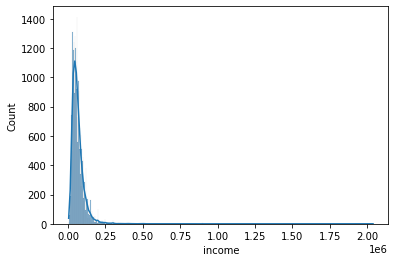

In [32]:
#INCOME
sns.histplot(df3['income'], kde=True)

<Axes: xlabel='loan_amnt', ylabel='Count'>

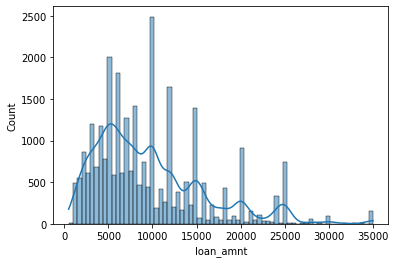

In [33]:
#LOAN AMOUNTS
sns.histplot(df3['loan_amnt'], kde=True)

In [34]:
#HOME OWNERSHIP
fig=px.histogram(df3, x = 'home_ownership', histnorm = 'percent', text_auto = '.2f',template = 'presentation', title = 'Home Ownership')
fig.update_layout()
fig.show()

'employment_length' 
'loan_intent', 'loan_grade', 'loan_int_rate',
'is_default', 'default_history'

## 3.2 Bivariate Analysis

## 3.3 Multivariate Analysis

# 4.0 Fliltering Variables

In [35]:
df4 = df3.copy()

In [36]:
df4.columns

Index(['index', 'age', 'income', 'home_ownership', 'employment_length',
       'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'is_default',
       'loan_percent_income', 'default_history', 'credit_history_length',
       'age_group', 'income_group', 'loan_amnt_group', 'loan_to_income',
       'loan_to_emp_len', 'int_rate_to_loan'],
      dtype='object')

In [37]:
cols_drop = ['index', 'is_default']

num_cols = ['age', 'income', 'employment_length', 
'loan_amnt', 'loan_int_rate',
'loan_percent_income', 'credit_history_length',
'loan_to_income', 'loan_to_emp_len', 
'int_rate_to_loan']

cat_cols = ['home_ownership', 'loan_intent', 'loan_grade', 'default_history', 'age_group', 'income_group', 'loan_amnt_group']

# 5.0 Preprocessing Data

In [38]:
X = df4.drop(cols_drop, axis=1)
Y = df4['is_default']

In [61]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, stratify=Y, random_state=12)

In [62]:
print(x_train.shape, x_test.shape)

(22905, 17) (5727, 17)


In [63]:
x_train.reset_index(inplace=True)
x_test.reset_index(inplace=True)

In [64]:
x_train.columns

Index(['index', 'age', 'income', 'home_ownership', 'employment_length',
       'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'default_history', 'credit_history_length',
       'age_group', 'income_group', 'loan_amnt_group', 'loan_to_income',
       'loan_to_emp_len', 'int_rate_to_loan'],
      dtype='object')

## 5.1 Encoding

In [65]:
ohe = OneHotEncoder()
ohe.fit(x_train[cat_cols])

OneHotEncoder()

In [66]:
ohe.categories_

[array(['MORTGAGE', 'OTHER', 'OWN', 'RENT'], dtype=object),
 array(['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL',
        'PERSONAL', 'VENTURE'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['adult', 'elderly', 'late_adulthood', 'young_adult', nan],
       dtype=object),
 array(['high', 'high_middle', 'low', 'low_middle', 'middle'], dtype=object),
 array(['large', 'medium', 'small', 'very_large'], dtype=object)]

In [67]:
merge_ohe_col = np.concatenate((ohe.categories_[0], 
ohe.categories_[1],
ohe.categories_[2],
ohe.categories_[3],
ohe.categories_[4],
ohe.categories_[5],
ohe.categories_[6]))

In [68]:
merge_ohe_col


array(['MORTGAGE', 'OTHER', 'OWN', 'RENT', 'DEBTCONSOLIDATION',
       'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'N', 'Y', 'adult', 'elderly',
       'late_adulthood', 'young_adult', nan, 'high', 'high_middle', 'low',
       'low_middle', 'middle', 'large', 'medium', 'small', 'very_large'],
      dtype=object)

In [69]:
ohe_data = pd.DataFrame(ohe.transform(x_train[cat_cols]).toarray(), columns=merge_ohe_col)
ohe_data2 = pd.DataFrame(ohe.transform(x_test[cat_cols]).toarray(), columns=merge_ohe_col)

In [70]:
x_new = pd.concat([ohe_data, x_train], axis=1)
x_new = x_new.drop(cat_cols, axis=1)

x_new_test = pd.concat([ohe_data2, x_test], axis=1)
x_new_test = x_new_test.drop(cat_cols, axis=1)

## 5.2 Rescaling

In [71]:
scaler1 = StandardScaler()
x_new.loc[:, num_cols] = scaler1.fit_transform(x_new.loc[:, num_cols])
x_new_test.loc[:, num_cols] = scaler1.fit_transform(x_new_test.loc[:, num_cols])

In [76]:
x_new_test.head()

,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,...,age,income,employment_length,loan_amnt,loan_int_rate,loan_percent_income,credit_history_length,loan_to_income,loan_to_emp_len,int_rate_to_loan
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.215822,-0.284073,0.556010,-0.016989,0.517863,0.116096,-0.201401,0.124016,-0.029860,-0.284013
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.445324,1.763303,-0.942939,1.299781,-1.242714,-0.462397,-0.955600,-0.490964,-0.648320,-0.791886
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.381108,-0.792865,0.056360,0.359231,0.974877,2.526484,0.552798,2.503740,-0.316774,-0.360403
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.445324,-0.111084,-0.942939,1.299781,0.671223,1.176667,-0.955600,1.196846,-0.648320,-0.604128
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.610610,0.049694,0.805835,0.829506,0.674291,0.501758,-0.452800,0.460686,-0.209660,-0.524150


# 6.0 ML modeling

## 6.1 Average Model

In [104]:
aux1 = x_new_test.copy()
aux1['is_default'] = y_test.copy()

#prediction
aux2 = aux1[['index', 'is_default']].groupby('index').mean().reset_index().rename(columns={'is_default': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='index')
aux1.fillna('n', inplace = True)
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', y_test, yhat_baseline)
baseline_result

ValueError: could not convert string to float: 'n'

In [102]:
aux1.isna().sum()

MORTGAGE                 0
OTHER                    0
OWN                      0
RENT                     0
DEBTCONSOLIDATION        0
EDUCATION                0
HOMEIMPROVEMENT          0
MEDICAL                  0
PERSONAL                 0
VENTURE                  0
A                        0
B                        0
C                        0
D                        0
E                        0
F                        0
G                        0
N                        0
Y                        0
adult                    0
elderly                  0
late_adulthood           0
young_adult              0
NaN                      0
high                     0
high_middle              0
low                      0
low_middle               0
middle                   0
large                    0
medium                   0
small                    0
very_large               0
index                    0
age                      0
income                   0
employment_length        0
l

## 6.2 Linear Regression

In [105]:
#model
lr = LinearRegression().fit(x_new, y_train)

#prediction
yhat_lr = lr.predict(x_new_test)

#performance
#lr_result = ml_error('Linear Regression', y_test, yhat_lr)
#lr_result

TypeError: Feature names are only supported if all input features have string names, but your input has ['float', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [106]:
#model
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42).fit(x_new, y_train)

#prediction
yhat_rf = rf.predict(x_test)


TypeError: Feature names are only supported if all input features have string names, but your input has ['float', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

## 6.3 SVM

In [39]:
classifier = svm.SVC(kernel='linear')

In [ ]:
#training the support vector
classifier.fit(x_train, y_train)

# 7.0 Model Evaluation

In [ ]:
#accuracy score on training data
x_train_prediction = classifier.predict(x_train)
training_data_accuracy = accuracy_score(x_train_prediction, y_train)
training_data_accuracy

In [ ]:
#accuracy score on training data
x_test_prediction = classifier.predict(x_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)
test_data_accuracy